In [39]:
# code taken from the following website;
# https://towardsdatascience.com/predictive-analysis-rnn-lstm-and-gru-to-predict-water-consumption-e6bb3c2b4b02


import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np
import csv 
import matplotlib.dates as mdates


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from datetime import datetime

In [40]:
tf.random.set_seed(1234)

In [41]:
# reading the file
data = pd.read_csv('Daily Sales with Pkr conversion and daily covid cases.csv',)

data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

In [42]:
# filtering dataset by date column

data = data.loc['2017-04-01':'2021-12-01']




In [43]:
data.head(10)

,Sales,Dollar to Pkr,Total Cases,Daily Cases
Date,,,,
2017-04-01,16748,104.810,NaN,0
2017-04-02,11340,104.810,NaN,0
2017-04-03,5331,104.810,NaN,0
2017-04-04,1300,104.800,NaN,0
2017-04-06,14660,104.810,NaN,0
2017-04-07,15095,104.820,NaN,0
2017-04-08,3530,104.820,NaN,0
2017-04-09,33555,104.820,NaN,0
2017-04-10,3840,104.840,NaN,0


In [44]:
data

,Sales,Dollar to Pkr,Total Cases,Daily Cases
Date,,,,
2017-04-01,16748,104.81,NaN,0
2017-04-02,11340,104.81,NaN,0
2017-04-03,5331,104.81,NaN,0
2017-04-04,1300,104.80,NaN,0
2017-04-06,14660,104.81,NaN,0
...,...,...,...,...
2021-11-24,12402,175.30,1283223.0,363
2021-11-25,23054,175.11,1283475.0,252
2021-11-26,7995,175.11,1283886.0,411


In [45]:
data['Sales_mavg'] = data['Sales'].rolling(window=14).mean()         # weekly average

In [46]:
data

,Sales,Dollar to Pkr,Total Cases,Daily Cases,Sales_mavg
Date,,,,,
2017-04-01,16748,104.81,NaN,0,NaN
2017-04-02,11340,104.81,NaN,0,NaN
2017-04-03,5331,104.81,NaN,0,NaN
2017-04-04,1300,104.80,NaN,0,NaN
2017-04-06,14660,104.81,NaN,0,NaN
...,...,...,...,...,...
2021-11-24,12402,175.30,1283223.0,363,20091.000000
2021-11-25,23054,175.11,1283475.0,252,20171.000000
2021-11-26,7995,175.11,1283886.0,411,20249.928571


In [47]:
data = data.loc['2017-06-01':'2021-12-01']


In [48]:
data

,Sales,Dollar to Pkr,Total Cases,Daily Cases,Sales_mavg
Date,,,,,
2017-06-01,4746,104.755,NaN,0,7584.928571
2017-06-03,4484,104.700,NaN,0,7798.071429
2017-06-04,17902,104.700,NaN,0,8725.000000
2017-06-05,1050,104.740,NaN,0,7665.714286
2017-06-06,1440,104.850,NaN,0,7491.785714
...,...,...,...,...,...
2021-11-24,12402,175.300,1283223.0,363,20091.000000
2021-11-25,23054,175.110,1283475.0,252,20171.000000
2021-11-26,7995,175.110,1283886.0,411,20249.928571


Text(0, 0.5, 'Sales Moving avg')

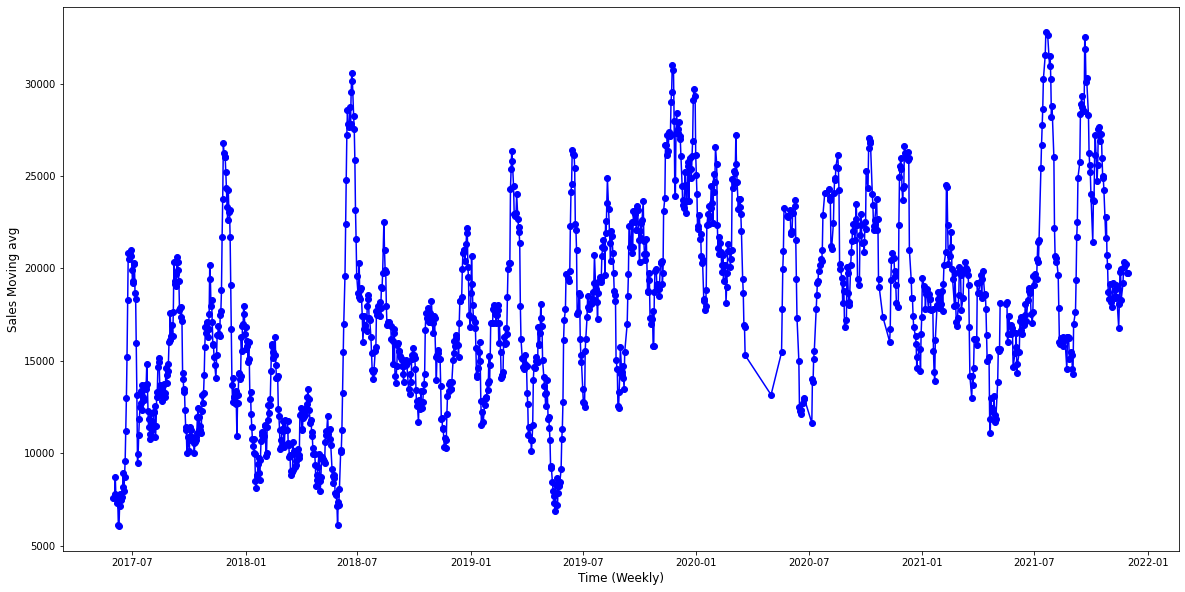

In [49]:
# view data

plt.figure(figsize=(20,10))
axes = plt.gca()



plt.plot(data.index, data['Sales_mavg'], color='blue')
# plt.plot(data.index, data['Sales']/7, color='orange')
# plt.plot(data.index, data['Weekly Cases'], color='orange')
# plt.plot(data.index, data['Dollar to Pkr'], color='purple')

plt.scatter(data.index, data['Sales_mavg'], color='blue')
# plt.scatter(data.index, data['Sales']/7, color='orange')
# plt.scatter(data.index, data['Weekly Cases'], color='orange')
# plt.scatter(data.index, data['Dollar to Pkr'], color='purple')

plt.xlabel('Time (Weekly)', {'fontsize': 12}) 
plt.ylabel('Sales Moving avg', {'fontsize': 12})


In [50]:
# check null values
data.isnull().sum()

Sales              0
Dollar to Pkr      0
Total Cases      855
Daily Cases        0
Sales_mavg         0
dtype: int64

In [51]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)

replace_missing(data['Dollar to Pkr'])

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:6915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [52]:
# check for missing values again
data.isnull().sum()

Sales              0
Dollar to Pkr      0
Total Cases      855
Daily Cases        0
Sales_mavg         0
dtype: int64

In [53]:
# Outlier detection
# for now adjusting the sales column only
up_b = data['Sales'].mean() + 2*data['Sales'].std()
low_b = data['Sales'].mean() - 2*data['Sales'].std()

data.loc[data['Sales'] > up_b, 'Sales'] = np.nan
data.loc[data['Sales'] < low_b, 'Sales'] = np.nan
data['Sales'].interpolate(inplace=True)


up_b = data['Sales_mavg'].mean() + 2*data['Sales_mavg'].std()
low_b = data['Sales_mavg'].mean() - 2*data['Sales_mavg'].std()

data.loc[data['Sales_mavg'] > up_b, 'Sales_mavg'] = np.nan
data.loc[data['Sales_mavg'] < low_b, 'Sales_mavg'] = np.nan
data['Sales_mavg'].interpolate(inplace=True)


# according to my understanding, the dependent variables should also get adjusted

up_b = data['Dollar to Pkr'].mean() + 2*data['Dollar to Pkr'].std()
low_b = data['Dollar to Pkr'].mean() - 2*data['Dollar to Pkr'].std()

data.loc[data['Dollar to Pkr'] > up_b, 'Dollar to Pkr'] = np.nan
data.loc[data['Dollar to Pkr'] < low_b, 'Dollar to Pkr'] = np.nan
data['Dollar to Pkr'].interpolate(inplace=True)

# up_b = data['Weekly Cases'].mean() + 2*data['Weekly Cases'].std()
# low_b = data['Weekly Cases'].mean() - 2*data['Weekly Cases'].std()

# data.loc[data['Weekly Cases'] > up_b, 'Weekly Cases'] = np.nan
# data.loc[data['Weekly Cases'] < low_b, 'Weekly Cases'] = np.nan
# data['Weekly Cases'].interpolate(inplace=True)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Dimension of train data:  (1024, 5)
Dimension of test data:  (257, 5)


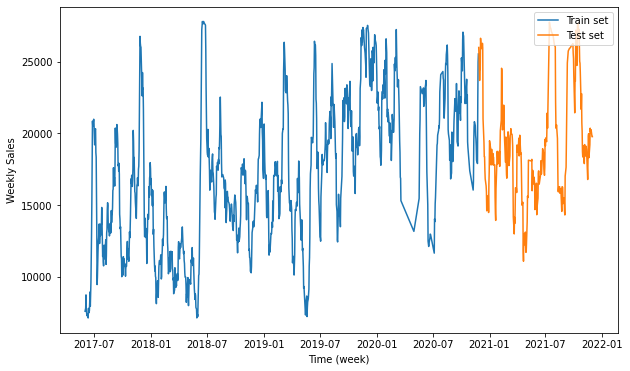

In [54]:
# Split train data and test data 80 - 20
train_size = int(len(data)*0.8)
train_dataset, test_dataset = data.iloc[:train_size],data.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.Sales_mavg)
plt.plot(test_dataset.Sales_mavg)
plt.xlabel('Time (week)')
plt.ylabel('Weekly Sales')
plt.legend(['Train set', 'Test set'], loc='upper right')

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [55]:
# Split train data to X and y
X_train = train_dataset.drop(['Sales', 'Sales_mavg', 'Daily Cases', 'Total Cases'], axis = 1)
y_train = train_dataset.loc[:,['Sales_mavg']]

# Split test data to X and y
X_test = test_dataset.drop(['Sales', 'Sales_mavg', 'Daily Cases', 'Total Cases'], axis = 1)
y_test = test_dataset.loc[:,['Sales_mavg']]




In [56]:
X_train

,Dollar to Pkr
Date,
2017-06-01,104.755
2017-06-03,104.700
2017-06-04,104.700
2017-06-05,104.740
2017-06-06,104.850
...,...
2020-11-20,160.050
2020-11-23,160.700
2020-11-24,160.300


In [57]:
# Different scaler for input and output because they have different shapes

scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [58]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 5

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)

print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (252, 5, 1)
y_train.shape:  (1019, 1)
X_test.shape:  (252, 5, 1)
y_test.shape:  (1019, 1)


In [59]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    # model.add(Bidirectional(LSTM(units = units/2)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='huber_loss', optimizer='adam')
    # model.compile(loss='mae', optimizer='adam')

    return model
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    # model.compile(loss='mse', optimizer='adam')
    # model.compile(loss='mae', optimizer='adam')
    model.compile(loss='huber_loss', optimizer='adam')
    return model
# BiLSTM
model_bilstm = create_model_bilstm(64)
# GRU and LSTM
# model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

In [60]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model, e):
    # early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
    #                                            patience = 10)
    history = model.fit(X_train, y_train, epochs = e,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False
                        # , callbacks = [early_stop]
                        )
    return history
history_bilstm = fit_model(model_bilstm, 200)
history_lstm = fit_model(model_lstm, 200)
# history_gru = fit_model(model_gru, 1000)

Epoch 1/200
26/26 [==============================] - 7s 60ms/step - loss: 0.0372 - val_loss: 0.0170
Epoch 2/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0325 - val_loss: 0.0399
Epoch 3/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0317 - val_loss: 0.0209
Epoch 4/200
26/26 [==============================] - 0s 16ms/step - loss: 0.0255 - val_loss: 0.0234
Epoch 5/200
26/26 [==============================] - 0s 19ms/step - loss: 0.0247 - val_loss: 0.0248
Epoch 6/200
26/26 [==============================] - 0s 18ms/step - loss: 0.0246 - val_loss: 0.0244
Epoch 7/200
26/26 [==============================] - 0s 14ms/step - loss: 0.0245 - val_loss: 0.0241
Epoch 8/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0244 - val_loss: 0.0239
Epoch 9/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 10/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0243 - val_loss: 0.0235
Epoc

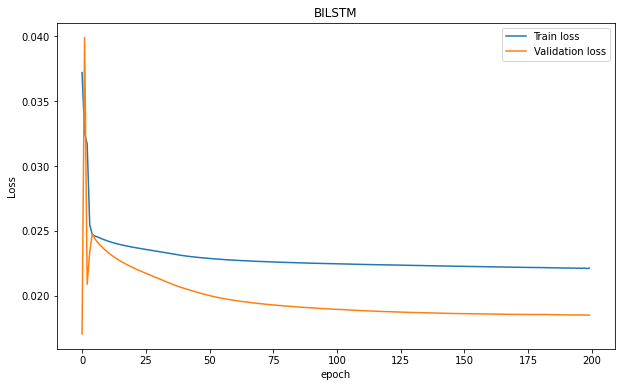

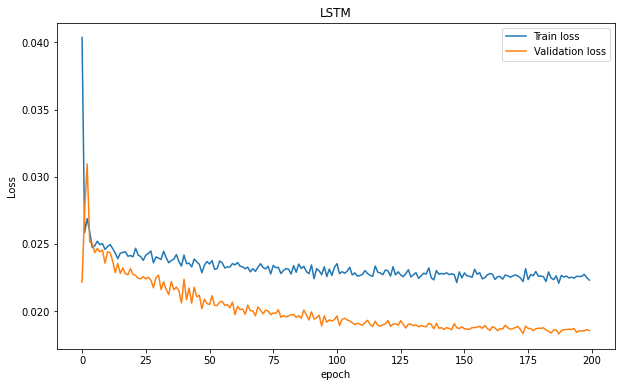

In [61]:
def plot_loss (history, name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.title(name)
plot_loss (history_bilstm, 'BILSTM')
plot_loss (history_lstm, 'LSTM')
# plot_loss (history_gru)

In [62]:
# transform target variable back to original data space

y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

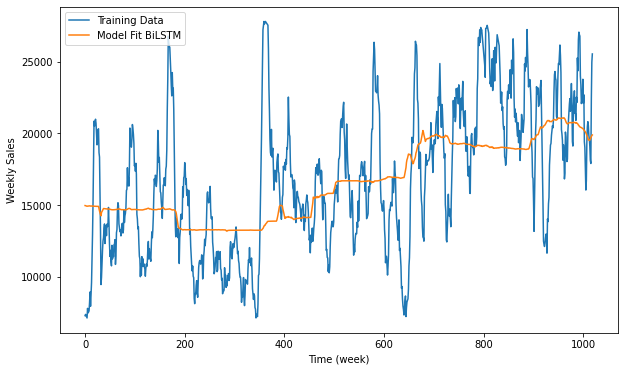

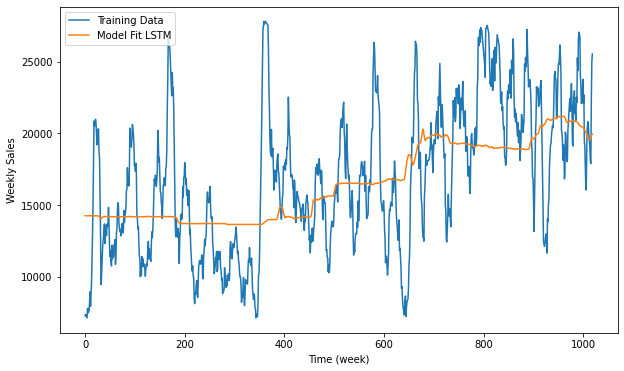

In [63]:
# view model fitting on training dataset
def model_fitting(model):
    prediction = model.predict(X_train)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
    
bilstm_fit = model_fitting(model_bilstm)
lstm_fit = model_fitting(model_lstm)

def plot_fit(fit, y_train, name):
    plt.figure(figsize=(10, 6))
    range_future = len(fit)
    plt.plot(np.arange(range_future), np.array(y_train), 
             label='Training Data')     
    plt.plot(np.arange(range_future),np.array(fit),
            label='Model Fit ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (week)')
    plt.ylabel('Weekly Sales')
    
plot_fit(bilstm_fit, y_train, 'BiLSTM')
plot_fit(lstm_fit, y_train, 'LSTM')


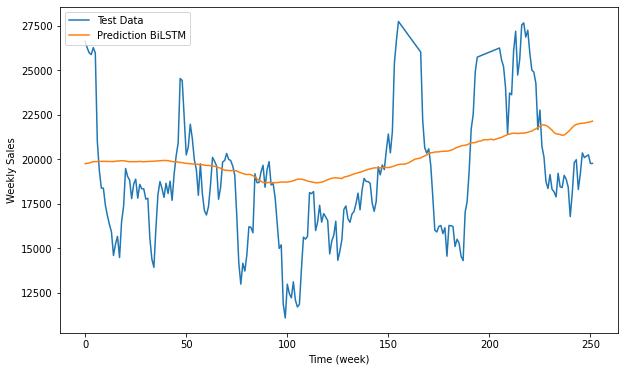

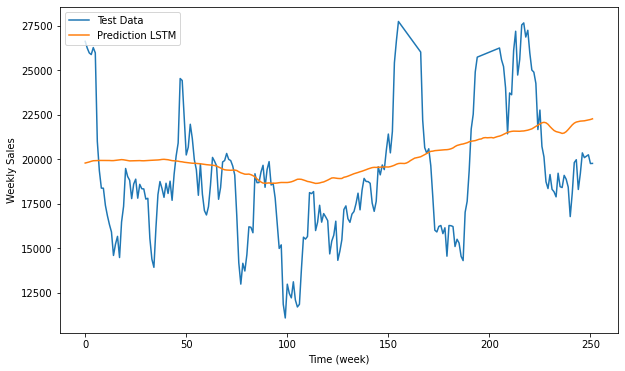

In [64]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
# prediction_gru = prediction(model_gru)

# Plot true future vs prediction
def plot_future(prediction, y_test, name):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test Data')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction ' + name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (week)')
    plt.ylabel('Weekly Sales')
plot_future(prediction_bilstm, y_test, 'BiLSTM')
plot_future(prediction_lstm, y_test, 'LSTM')
# plot_future(prediction_gru, y_test, 'GRU')

In [65]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
# evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 3036.5849
Root Mean Square Error: 3689.7493

LSTM:
Mean Absolute Error: 3041.4853
Root Mean Square Error: 3686.6360

